In [6]:
import sys
import os

import shap
shap.initjs()
# from pathlib import Path
# import pandas as pd
# import warnings

# Add the Regression sister folder to sys.path
regression_folder_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Regression'))
sys.path.append(regression_folder_path)

# Import modules
from Regression_variables import *

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"


### Use random forrest, random split and TPE sampler w/ best params
### n_est = 323
### max_depth = 8 #not too deep so as to avoid overfitting
### min_sample_split = 2
### min_sample_leaf = 1
### x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)


# SHAP Values

In [7]:
best_n_estimators_rand_TPE = 323
best_max_depth_rand_TPE = 8
best_min_samples_split_rand_TPE = 2
best_min_samples_leaf_rand_TPE = 1


rfr_rand_best_TPE = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE, max_depth=best_max_depth_rand_TPE, min_samples_split=best_min_samples_split_rand_TPE, min_samples_leaf=best_min_samples_leaf_rand_TPE)
rfr_rand_best_TPE.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best_TPE = rfr_rand_best_TPE.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best_TPE = mean_absolute_error(y_test_rand, y_pred_rfr_rand_best_TPE)
mse_rfr_rand_best_TPE = mean_squared_error(y_test_rand, y_pred_rfr_rand_best_TPE)
r2_rfr_rand_best_TPE = r2_score(y_test_rand, y_pred_rfr_rand_best_TPE)

In [8]:
explainer = shap.Explainer(rfr_rand_best_TPE)
shap_values = explainer(np.array(list((x_train_rand))).astype(float))

In [9]:
np.shape(shap_values.values)
#MACCS keys are 166bit structural key descriptors

(476, 167)

# Waterfall Plot
### This tells us the waterfall plot for the first observation LHS 0 and 1 show the actual value of obs 1. Feature # tells us the MACCS bit we are looking at. The arrow tells us how the feature has contributed to the pIC50 prediction

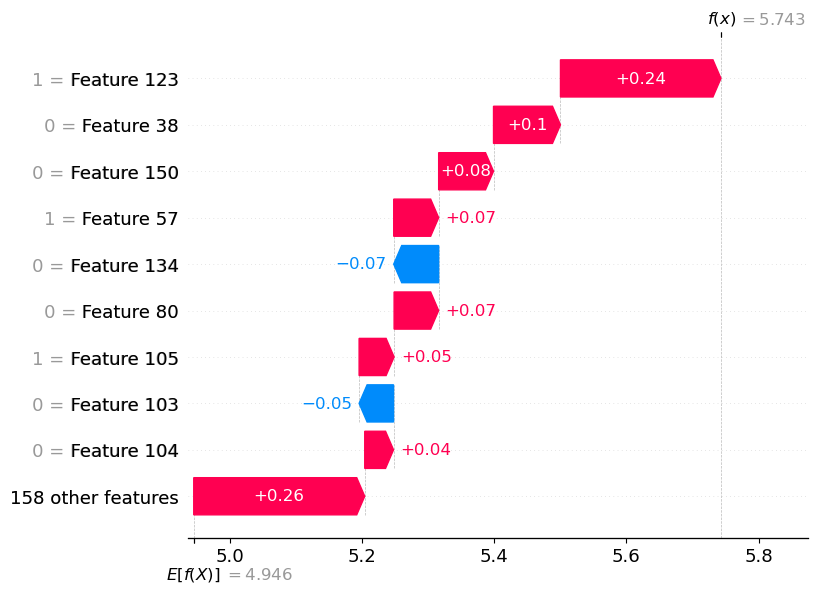

In [10]:
shap.plots.waterfall(shap_values[0])


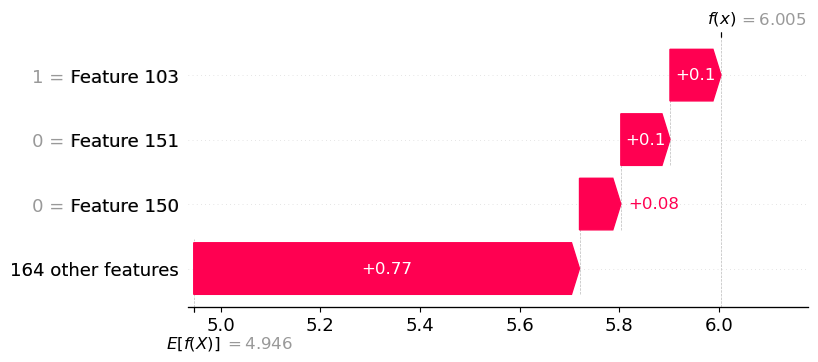

In [17]:
shap.plots.waterfall(shap_values[1], max_display=4)

# Force Plot

In [18]:
# a consended waterfall plot
shap.plots.force(shap_values[0])

# Stacked force plot
### Each of the individual force plots has been flipped 90 degrees and stacked side by side (vertically)

In [19]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP Plot
### Which features are most important to the MODEL
### Each bar gives absolute mean SHAP value for each feature. Features that have made large positive or negative contributions are at the top. 

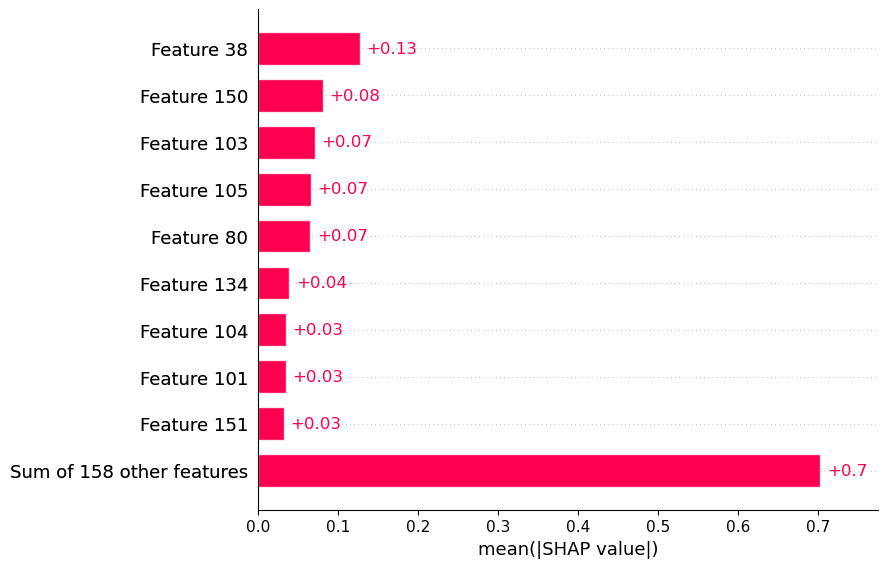

<Figure size 640x480 with 0 Axes>

In [20]:
shap.plots.bar(shap_values)
# save figure
plt.savefig('shap_plt_ABS_rand_TPE.png', dpi=300, bbox_inches='tight')

# Beeswarm Plot
### A visualisation of all of the SHAP values
### y axis: Feature #
### x axis: SHAP value
### colour: determined by the feature values 
### We can see which features have large positive or large negative SHAP values. Features have been ordered in same order in abs mean plot
### There is no gradient here as the feature value is binary [0,1]
### Feature 38: a value of 1 contributes to a negative SHAP value whilse for feature 103 this is the opposite. 

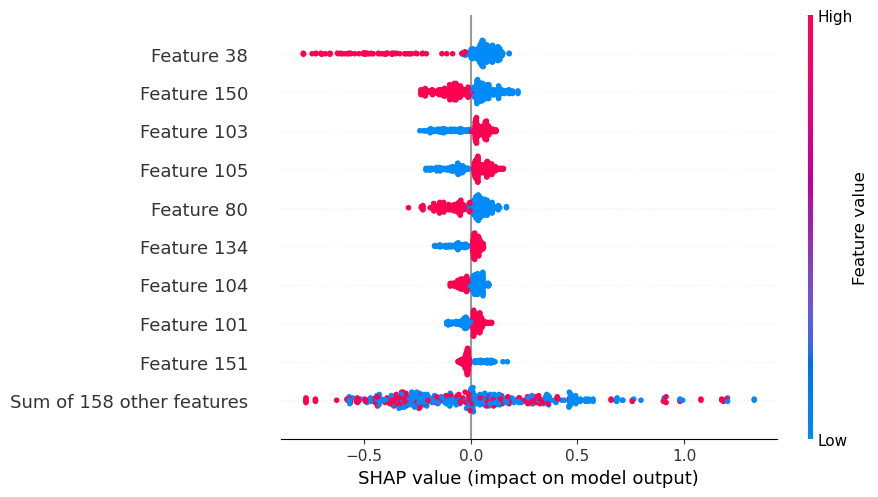

<Figure size 640x480 with 0 Axes>

In [21]:
shap.plots.beeswarm(shap_values)
# save figure
plt.savefig('shap_plt_beeswarm_rand_TPE.png', dpi=300, bbox_inches='tight')